# System Checks

In [2]:
import tensorflow as tf

# Check if GPU is available and ready
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


2024-10-15 00:13:03.300611: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 00:13:30.483303: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-10-15 00:13:30.484692: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

Num GPUs Available:  1


2024-10-15 00:13:46.567045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-15 00:13:48.210276: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-15 00:13:48.214808: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
# Install dependencies for the project
# Install the necessary dependencies
!pip install tensorflow imageio google-cloud-storage requests


In [4]:
from google.cloud import storage
client = storage.Client()

# Example: List buckets
for bucket in client.list_buckets():
    print(bucket.name)


arcane-stack-438402-k9-us-notebooks
buketgif
cloud-ai-platform-7ceb4d9a-6ff1-4c81-b3d7-1f448766d621
whathegifbucket


# Loading Data from GCS Bucket

In [5]:
import pandas as pd

# Load the TSV file from Google Cloud Storage (update with your actual GCS path)
tsv_file_path = 'gs://whathegifbucket/tgif-v2.0.tsv'  # Replace this with your actual path
df = pd.read_csv(tsv_file_path, sep='\t')

# Display the first few rows to check if it's loaded correctly
print("Preview of the dataset:")
print(df.head())

Preview of the dataset:
   Unnamed: 0                                              links  \
0           1  https://38.media.tumblr.com/9f6c25cc350f12aa74...   
1           2  https://38.media.tumblr.com/9ead028ef62004ef6a...   
2           3  https://38.media.tumblr.com/9f43dc410be85b1159...   
3           4  https://38.media.tumblr.com/9f659499c8754e40cf...   
4           5  https://38.media.tumblr.com/9ed1c99afa7d714118...   

                                         description  
0  a man is glaring, and someone with sunglasses ...  
1           a cat tries to catch a mouse on a tablet  
2                   a man dressed in red is dancing.  
3     an animal comes close to another in the jungle  
4  a man in a hat adjusts his tie and makes a wei...  


# Processing GIFs and saving into GCS Bucket and Json Format

In [10]:
import numpy as np
from urllib.request import urlopen
from PIL import Image, UnidentifiedImageError
from io import BytesIO

# Test with one GIF URL from the dataset
test_gif_url = df['links'].iloc[0]  # Taking the first GIF URL in the dataset

def check_single_gif_pillow(gif_url):
    try:
        # Stream the GIF directly from the URL
        with urlopen(gif_url) as response:
            content_type = response.headers.get('Content-Type')
            print(f"Checking URL: {gif_url} -> Content-Type: {content_type}")
            
            if content_type != 'image/gif':
                print(f"Skipping {gif_url}, it is not a valid GIF.")
                return
            
            # Read the GIF using Pillow
            gif_bytes = response.read()
            gif = Image.open(BytesIO(gif_bytes))
            
            # Extract frames and convert to numpy arrays
            gif_frames = []
            try:
                while True:
                    frame = np.array(gif.convert('RGB'))  # Convert to RGB
                    gif_frames.append(frame)
                    gif.seek(gif.tell() + 1)  # Move to the next frame
            except EOFError:
                pass  # End of GIF reached
            
            print(f"Number of frames in GIF: {len(gif_frames)}")
            gif_frames = np.array(gif_frames)
            print(f"Processed GIF shape: {gif_frames.shape}")

            # Resize frames to 224x224
            resized_frames = np.array([resize_frame(frame, (224, 224)) for frame in gif_frames])
            print(f"Resized GIF shape: {resized_frames.shape}")

    except (URLError, HTTPError, UnidentifiedImageError) as e:
        print(f"Error processing GIF from {gif_url}: {e}")

# Function to resize the frames to 224x224
def resize_frame(frame, size):
    return np.array(Image.fromarray(frame).resize(size))

# Test one GIF from the dataset using Pillow
check_single_gif_pillow(test_gif_url)


Checking URL: https://38.media.tumblr.com/9f6c25cc350f12aa74a7dc386a5c4985/tumblr_mevmyaKtDf1rgvhr8o1_500.gif -> Content-Type: image/gif
Number of frames in GIF: 18
Processed GIF shape: (18, 243, 500, 3)
Resized GIF shape: (18, 224, 224, 3)


In [12]:
import json
import numpy as np
from urllib.request import urlopen
from urllib.error import URLError, HTTPError
from PIL import Image, UnidentifiedImageError
from google.cloud import storage
from io import BytesIO
from tqdm import tqdm

# Initialize Google Cloud Storage client
client = storage.Client()
bucket_name = "whathegifbucket"  # Replace with your actual GCS bucket name
bucket = client.get_bucket(bucket_name)

# Function to check if the URL points to a valid GIF
def is_valid_gif(url):
    try:
        with urlopen(url) as response:
            content_type = response.headers.get('Content-Type')
            print(f"Checking URL: {url} -> Content-Type: {content_type}")
            return content_type == 'image/gif'
    except (URLError, HTTPError) as e:
        print(f"Failed to connect to {url}: {e}")
        return False

# Function to stream, augment, and process GIF using Pillow
def stream_augment_and_process_gif_pillow(gif_url, gif_id):
    if not is_valid_gif(gif_url):
        print(f"Skipping {gif_url}, it is not a valid GIF.")
        return None
    
    try:
        # Stream the GIF directly from the URL
        with urlopen(gif_url) as response:
            gif_bytes = response.read()
            gif = Image.open(BytesIO(gif_bytes))
        
        # Extract frames and convert them to numpy arrays
        gif_frames = []
        try:
            while True:
                frame = np.array(gif.convert('RGB'))  # Convert to RGB
                gif_frames.append(frame)
                gif.seek(gif.tell() + 1)  # Move to the next frame
        except EOFError:
            pass  # End of GIF reached
        
        # Ensure the GIF has frames
        if len(gif_frames) == 0:
            print(f"Skipping {gif_url}, no frames found.")
            return None
        
        # Convert to numpy array and resize frames
        gif_frames = np.array(gif_frames)
        resized_frames = np.array([resize_frame(frame, (224, 224)) for frame in gif_frames])
        
        # Ensure all GIFs have exactly 16 frames by trimming or padding as needed
        processed_frames = pad_or_trim_frames(resized_frames, target_frame_count=16)

        # Save the processed frames to GCS using BytesIO
        save_path = f"processed_gifs_augmented/{gif_id}_frames.npy"
        blob = bucket.blob(save_path)
        
        # Convert numpy array to bytes and upload
        with BytesIO() as output:
            np.save(output, processed_frames)
            blob.upload_from_string(output.getvalue(), content_type='application/octet-stream')
        
        return save_path

    except (URLError, HTTPError, UnidentifiedImageError) as e:
        print(f"Error processing GIF from {gif_url}: {e}")
        return None

# Function to resize frames to 224x224 pixels
def resize_frame(frame, size):
    return np.array(Image.fromarray(frame).resize(size))

# Function to pad or trim frames to ensure each GIF has exactly 16 frames
def pad_or_trim_frames(frames, target_frame_count=16):
    num_frames = len(frames)
    if num_frames > target_frame_count:
        return frames[:target_frame_count]  # Trim excess frames
    elif num_frames < target_frame_count:
        # Pad by repeating the last frame until the target frame count is reached
        pad_size = target_frame_count - num_frames
        padding = np.repeat(frames[-1:], pad_size, axis=0)
        return np.concatenate([frames, padding], axis=0)
    return frames

# List to hold all GIF metadata for augmentation and processing
gif_metadata_augmented = []

# Process and save the first 100 GIFs from the dataset
for i, row in tqdm(df.iterrows(), total=100):  # tqdm adds the progress bar for tracking
    if i >= 100:  # Limit to processing only the first 100 GIFs
        break

    gif_url = row['links']  # Using the correct 'links' column for GIF URLs
    description = row['description']
    gif_id = f"gif_{i+1}"

    # Stream, augment, and process the GIF using Pillow
    processed_gif_path = stream_augment_and_process_gif_pillow(gif_url, gif_id)

    if processed_gif_path:  # Only save metadata if the GIF was successfully processed
        # Append the metadata for this GIF to the list
        gif_metadata_augmented.append({
            "GIF_ID": gif_id,
            "URL": gif_url,
            "processed_gif_path": processed_gif_path,  # Path to the processed .npy file
            "description": description  # Ground truth description for evaluation
        })

# Save all augmented GIF metadata to a JSON file
with open('gif_metadata_augmented.json', 'w') as json_file:
    json.dump(gif_metadata_augmented, json_file)

print("Augmented GIF metadata saved to gif_metadata_augmented.json")


  0%|          | 0/100 [00:00<?, ?it/s]

Checking URL: https://38.media.tumblr.com/9f6c25cc350f12aa74a7dc386a5c4985/tumblr_mevmyaKtDf1rgvhr8o1_500.gif -> Content-Type: image/gif


  1%|          | 1/100 [00:00<01:21,  1.22it/s]

Checking URL: https://38.media.tumblr.com/9ead028ef62004ef6ac2b92e52edd210/tumblr_nok4eeONTv1s2yegdo1_400.gif -> Content-Type: image/gif


  2%|▏         | 2/100 [00:01<01:26,  1.13it/s]

Checking URL: https://38.media.tumblr.com/9f43dc410be85b1159d1f42663d811d7/tumblr_mllh01J96X1s9npefo1_250.gif -> Content-Type: image/gif


  3%|▎         | 3/100 [00:02<01:15,  1.28it/s]

Checking URL: https://38.media.tumblr.com/9f659499c8754e40cf3f7ac21d08dae6/tumblr_nqlr0rn8ox1r2r0koo1_400.gif -> Content-Type: image/gif


  4%|▍         | 4/100 [00:03<01:22,  1.17it/s]

Checking URL: https://38.media.tumblr.com/9ed1c99afa7d71411884101cb054f35f/tumblr_mvtuwlhSkE1qbnleeo1_500.gif -> Content-Type: image/gif


  5%|▌         | 5/100 [00:04<01:21,  1.17it/s]

Checking URL: https://38.media.tumblr.com/9e437d26769cb2ac4217df14dbb20034/tumblr_npw7v7W07C1tmj047o1_250.gif -> Content-Type: image/gif


  6%|▌         | 6/100 [00:05<01:22,  1.14it/s]

Checking URL: https://38.media.tumblr.com/9e4ab65c0e7d4bb8aa6b5be854b83794/tumblr_mdlv9v6hE91qanrf2o1_r11_500.gif -> Content-Type: image/gif


  7%|▋         | 7/100 [00:05<01:19,  1.17it/s]

Checking URL: https://38.media.tumblr.com/9ecd3483028290171dcb5e920ff4e3bb/tumblr_nkcmeflaVj1u26rdio1_500.gif -> Content-Type: image/gif


  8%|▊         | 8/100 [00:06<01:15,  1.21it/s]

Checking URL: https://38.media.tumblr.com/9f83754d20ce882224ae3392a8372ee8/tumblr_mkwd0y8Poo1qlnbq8o1_400.gif -> Content-Type: image/gif


  9%|▉         | 9/100 [00:07<01:12,  1.26it/s]

Checking URL: https://38.media.tumblr.com/9f4cb2977d5cd905f57293ac506b9db8/tumblr_msij5q4Run1qd76t9o1_500.gif -> Content-Type: image/gif


 10%|█         | 10/100 [00:08<01:14,  1.22it/s]

Checking URL: https://38.media.tumblr.com/9e6fcb37722bf01996209bdf76708559/tumblr_np9xo74UgD1ux4g5vo1_250.gif -> Content-Type: image/gif


 11%|█         | 11/100 [00:09<01:10,  1.26it/s]

Checking URL: https://38.media.tumblr.com/881302bfd0245614cb165636887cfed6/tumblr_noncfelojf1uqmy01o1_500.gif -> Content-Type: image/gif


 12%|█▏        | 12/100 [00:09<01:09,  1.27it/s]

Checking URL: https://38.media.tumblr.com/886236e83a1a1b6ae9f4dc43509f2fe6/tumblr_nov5tja4g91rkmzrjo1_400.gif -> Content-Type: image/gif


 13%|█▎        | 13/100 [00:10<01:07,  1.29it/s]

Checking URL: https://38.media.tumblr.com/88817768f0c3b54c7a1b58908037ca1f/tumblr_nq7f66LEk41tzifluo1_400.gif -> Content-Type: image/gif


 14%|█▍        | 14/100 [00:11<01:05,  1.30it/s]

Checking URL: https://38.media.tumblr.com/88de8efed91578715420f8a93c5e3da6/tumblr_nq3ofebQo51s4vpwjo1_500.gif -> Content-Type: image/gif


 15%|█▌        | 15/100 [00:12<01:10,  1.20it/s]

Checking URL: https://38.media.tumblr.com/8952c98f05a5f01377ac98c041cfe63e/tumblr_nqofwqgS8d1siem3jo1_r1_400.gif -> Content-Type: image/gif


 16%|█▌        | 16/100 [00:13<01:16,  1.09it/s]

Checking URL: https://38.media.tumblr.com/881416379772a539d5bb311c5bab9cd9/tumblr_nmzcu205yo1qdj2qoo1_500.gif -> Content-Type: image/gif


 17%|█▋        | 17/100 [00:14<01:12,  1.14it/s]

Checking URL: https://38.media.tumblr.com/88bd6013c943b41c93f685e0577b451c/tumblr_noxbsuCyAg1tjhed2o1_500.gif -> Content-Type: image/gif


 18%|█▊        | 18/100 [00:15<01:10,  1.16it/s]

Checking URL: https://38.media.tumblr.com/8911141195ce21e492761edba81ef309/tumblr_n4hv5jJDcS1t96jpzo1_500.gif -> Content-Type: image/gif


 19%|█▉        | 19/100 [00:15<01:07,  1.20it/s]

Checking URL: https://38.media.tumblr.com/88091baac04b18ef73d93e56883dccfe/tumblr_npzfsr13I51uyqfd5o1_500.gif -> Content-Type: image/gif


 20%|██        | 20/100 [00:16<01:04,  1.24it/s]

Checking URL: https://38.media.tumblr.com/89160d6633d04d4a9c8e7c8085f1c74d/tumblr_nqmgdj8STn1rn1g1jo1_250.gif -> Content-Type: image/gif


 21%|██        | 21/100 [00:17<01:03,  1.25it/s]

Checking URL: https://38.media.tumblr.com/8852d21ad80d138416453eb968ee97bc/tumblr_npntschfQp1qf69tyo1_500.gif -> Content-Type: image/gif


 22%|██▏       | 22/100 [00:18<01:00,  1.28it/s]

Checking URL: https://38.media.tumblr.com/88976e0d8b0e068ebdb114ad9226b66a/tumblr_nmp0m0o3Iv1r44r7zo1_500.gif -> Content-Type: image/gif


 24%|██▍       | 24/100 [00:19<00:48,  1.57it/s]

Checking URL: https://38.media.tumblr.com/8f5d9f86ebefa35baeadaba5337d09fc/tumblr_nox28g9fv41tfkobto1_500.gif -> Content-Type: image/png
Skipping https://38.media.tumblr.com/8f5d9f86ebefa35baeadaba5337d09fc/tumblr_nox28g9fv41tfkobto1_500.gif, it is not a valid GIF.
Checking URL: https://38.media.tumblr.com/90a1a65d2e1608451e84e2fe4bd16d04/tumblr_npse2pIimv1tyncywo1_400.gif -> Content-Type: image/gif


 25%|██▌       | 25/100 [00:19<00:51,  1.46it/s]

Checking URL: https://38.media.tumblr.com/902d6ba5bec4cf7a593cdc111fa88f6a/tumblr_n0lv33BBrb1rc0kvpo1_r1_250.gif -> Content-Type: image/gif


 26%|██▌       | 26/100 [00:20<00:53,  1.38it/s]

Checking URL: https://38.media.tumblr.com/8f8d0f7a02f4ade5527ffd63ee9883fd/tumblr_np2k4xqcDt1s9b6vho1_500.gif -> Content-Type: image/gif


 27%|██▋       | 27/100 [00:21<00:57,  1.26it/s]

Checking URL: https://38.media.tumblr.com/909c68e83bf7299c07c53753b7f57366/tumblr_nntpx3AxcV1tyncywo1_500.gif -> Content-Type: image/gif


 28%|██▊       | 28/100 [00:22<01:07,  1.07it/s]

Checking URL: https://38.media.tumblr.com/8f7fabf26213fb6a683419f5a48d326d/tumblr_no5kyk0Mgs1urjsaqo1_400.gif -> Content-Type: image/gif


 29%|██▉       | 29/100 [00:23<01:02,  1.13it/s]

Checking URL: https://38.media.tumblr.com/8fd8930ec4e3458c1e616d6002e6a53f/tumblr_nqq3ibcw841rvg72ao1_400.gif -> Content-Type: image/gif


 30%|███       | 30/100 [00:24<01:02,  1.12it/s]

Checking URL: https://38.media.tumblr.com/8f976a0c90d91d940223d3a76de5006e/tumblr_mudwwxBWdn1qm26qzo1_500.gif -> Content-Type: image/gif


 31%|███       | 31/100 [00:25<00:58,  1.19it/s]

Checking URL: https://38.media.tumblr.com/8f6110a0ec6a7409579b878ba09ae62f/tumblr_nq07jm1AQ51sja1kdo1_500.gif -> Content-Type: image/gif


 32%|███▏      | 32/100 [00:26<00:55,  1.22it/s]

Checking URL: https://38.media.tumblr.com/902f71ae45f50dc0a35c04323de6495a/tumblr_nj4iqcVaFQ1s26nzro1_500.gif -> Content-Type: image/gif


 33%|███▎      | 33/100 [00:26<00:53,  1.25it/s]

Checking URL: https://38.media.tumblr.com/900fe9102f650f3277c7c3d57ea095bb/tumblr_npo3mtQ87f1uxcyego1_400.gif -> Content-Type: image/gif


 34%|███▍      | 34/100 [00:27<00:52,  1.27it/s]

Checking URL: https://38.media.tumblr.com/901288b4a1c66c58571245623bca46f9/tumblr_nqexpu1pOL1sqicm1o1_500.gif -> Content-Type: image/gif


 35%|███▌      | 35/100 [00:28<00:48,  1.33it/s]

Checking URL: https://38.media.tumblr.com/8f53c46d4e2a40bc8dfc458fbd145cf1/tumblr_nq541zHa5n1uy63pco1_r1_250.gif -> Content-Type: image/gif


 36%|███▌      | 36/100 [00:29<00:47,  1.34it/s]

Checking URL: https://38.media.tumblr.com/8fb23a0c630d559029d1ed77a9a5959e/tumblr_nnxshbEKOc1rqd7uco1_500.gif -> Content-Type: image/gif


 37%|███▋      | 37/100 [00:29<00:47,  1.33it/s]

Checking URL: https://38.media.tumblr.com/8f5884647e1aaa0bda5677fbefec7ed4/tumblr_nq8ajiaBT71usj03ho1_500.gif -> Content-Type: image/gif


 38%|███▊      | 38/100 [00:30<00:46,  1.34it/s]

Checking URL: https://38.media.tumblr.com/8bf7c993adf5ba5ecea8ed946f8eb10e/tumblr_np5x4gNc1L1ux4ymjo1_500.gif -> Content-Type: image/gif


 39%|███▉      | 39/100 [00:31<00:45,  1.36it/s]

Checking URL: https://38.media.tumblr.com/8c4ee5c0338ad534042e85605b70c927/tumblr_npqraj6f5R1uuxd1yo1_500.gif -> Content-Type: image/gif


 40%|████      | 40/100 [00:32<00:44,  1.36it/s]

Checking URL: https://38.media.tumblr.com/8b67dd69640e5b12d55fdd8257319782/tumblr_no2up3t1Bv1usegjto1_250.gif -> Content-Type: image/gif


 41%|████      | 41/100 [00:32<00:45,  1.31it/s]

Checking URL: https://38.media.tumblr.com/8c90113076757a48a25a53942d829b02/tumblr_nl77cuGZWn1sm50zqo1_400.gif -> Content-Type: image/gif


 42%|████▏     | 42/100 [00:33<00:42,  1.35it/s]

Checking URL: https://38.media.tumblr.com/8beac80e7df8b66fc5d50d9f0679c527/tumblr_nnn5873T0c1uqclqmo1_500.gif -> Content-Type: image/gif


 43%|████▎     | 43/100 [00:34<00:42,  1.34it/s]

Checking URL: https://38.media.tumblr.com/8bf3197a0c9d0218d2fef5b428d2c143/tumblr_nowg4sfk6D1qzefc2o1_400.gif -> Content-Type: image/gif


 44%|████▍     | 44/100 [00:35<00:41,  1.34it/s]

Checking URL: https://38.media.tumblr.com/8b7e9aa41d080e9141a6f32fa4e7bbdc/tumblr_nohp6gAaLv1si7d5lo1_400.gif -> Content-Type: image/gif


 45%|████▌     | 45/100 [00:35<00:39,  1.39it/s]

Checking URL: https://38.media.tumblr.com/8cd34a2a68232f097b85f1839a2fd7a3/tumblr_npgxznNRd31uv0y2ro1_250.gif -> Content-Type: image/gif


 46%|████▌     | 46/100 [00:36<00:39,  1.35it/s]

Checking URL: https://38.media.tumblr.com/8cd949e726a9ec15950a4f4cda4eb330/tumblr_nq789eiheZ1r3kmkso1_1280.gif -> Content-Type: image/gif


 47%|████▋     | 47/100 [00:37<00:42,  1.23it/s]

Checking URL: https://38.media.tumblr.com/8c572ffffaad8065e52d3235bd0146b5/tumblr_nqrlhsLD931uzihc0o1_500.gif -> Content-Type: image/gif


 48%|████▊     | 48/100 [00:38<00:40,  1.29it/s]

Checking URL: https://38.media.tumblr.com/8bb63b757c40c499d2eccb9a2910d57b/tumblr_mgq9bwHRA51rhzq0oo1_500.gif -> Content-Type: image/gif


 49%|████▉     | 49/100 [00:38<00:39,  1.28it/s]

Checking URL: https://38.media.tumblr.com/8b8c94e0279cc6d2775ae08e0853f823/tumblr_nq5nstjatI1u1lytfo1_250.gif -> Content-Type: image/gif


 50%|█████     | 50/100 [00:39<00:37,  1.33it/s]

Checking URL: https://38.media.tumblr.com/8c14aa571911985d6d774762f8159452/tumblr_n4gk7efcMw1spy7ono1_400.gif -> Content-Type: image/gif


 51%|█████     | 51/100 [00:40<00:37,  1.31it/s]

Checking URL: https://38.media.tumblr.com/8cd3ac9b6db79b6fb1f52961bb173276/tumblr_nogx44forU1swlz57o1_500.gif -> Content-Type: image/gif


 52%|█████▏    | 52/100 [00:41<00:38,  1.25it/s]

Checking URL: https://38.media.tumblr.com/70f4c1fc63e69bafb2c0aafcc293d6ff/tumblr_npc3iyfpDC1ux3xido1_400.gif -> Content-Type: image/gif


 53%|█████▎    | 53/100 [00:42<00:37,  1.26it/s]

Checking URL: https://38.media.tumblr.com/70f2b88e7ef089a5d8d3722dfceb1e55/tumblr_n8tb4xoSOr1sxfqdyo1_1280.gif -> Content-Type: image/gif


 54%|█████▍    | 54/100 [00:42<00:36,  1.26it/s]

Checking URL: https://38.media.tumblr.com/6f8901961aa2ff3f85a105e844ced445/tumblr_nq2px77Scz1uycuzco1_500.gif -> Content-Type: image/gif


 55%|█████▌    | 55/100 [00:43<00:35,  1.27it/s]

Checking URL: https://38.media.tumblr.com/70af581598a20a1af31773cdab4b0321/tumblr_mxp686hce71sqec3to1_500.gif -> Content-Type: image/gif


 56%|█████▌    | 56/100 [00:44<00:33,  1.32it/s]

Checking URL: https://38.media.tumblr.com/6ff9ef1e816fed43fcf7e2f2498e1349/tumblr_nl33vmyhNi1u9vl8lo1_400.gif -> Content-Type: image/gif


 57%|█████▋    | 57/100 [00:45<00:34,  1.25it/s]

Checking URL: https://38.media.tumblr.com/709628e0cae3704db3eae23d10695d67/tumblr_nntf25N0Fx1uu6kufo1_250.gif -> Content-Type: image/gif


 58%|█████▊    | 58/100 [00:45<00:32,  1.29it/s]

Checking URL: https://38.media.tumblr.com/708a8a33362c8b2548c5b9a09463da49/tumblr_mtbdvn6y1D1rjj5sho1_400.gif -> Content-Type: image/gif


 59%|█████▉    | 59/100 [00:46<00:30,  1.33it/s]

Checking URL: https://38.media.tumblr.com/6fb91b85be51fd128be592d4618b6cf7/tumblr_noco9fFCqL1rpe4qfo1_500.gif -> Content-Type: image/gif


 60%|██████    | 60/100 [00:47<00:30,  1.29it/s]

Checking URL: https://38.media.tumblr.com/646593e337829d1ec07c41f628fbf431/tumblr_nju2re8NaP1ssgr2ko1_500.gif -> Content-Type: image/gif


 61%|██████    | 61/100 [00:48<00:30,  1.27it/s]

Checking URL: https://38.media.tumblr.com/64d21677dbcd80a0b1c83082817d9bb3/tumblr_noish93cHw1u4k0zeo1_500.gif -> Content-Type: image/gif


 62%|██████▏   | 62/100 [00:49<00:29,  1.31it/s]

Checking URL: https://38.media.tumblr.com/643522422670f705610510e57907fbec/tumblr_nqqpgscLkK1urwkppo1_400.gif -> Content-Type: image/gif


 63%|██████▎   | 63/100 [00:49<00:27,  1.33it/s]

Checking URL: https://38.media.tumblr.com/63bb0d748426c9cfb111917d2b8836d6/tumblr_mxtfcmpXuH1qgzzafo1_500.gif -> Content-Type: image/gif


 64%|██████▍   | 64/100 [00:50<00:26,  1.35it/s]

Checking URL: https://38.media.tumblr.com/6421efefaae5fd090d75fd2b98d1382e/tumblr_ne86njGv9l1trq9l0o1_500.gif -> Content-Type: image/gif


 65%|██████▌   | 65/100 [00:51<00:25,  1.35it/s]

Checking URL: https://38.media.tumblr.com/6453cb7a476ce87f7abcfb7149b171bd/tumblr_nqgz75OOEB1snj1pfo1_500.gif -> Content-Type: image/gif


 66%|██████▌   | 66/100 [00:52<00:26,  1.28it/s]

Checking URL: https://38.media.tumblr.com/64ccc75d23cf6a8a3a43f32988991bb6/tumblr_nonwd4NsEu1qhyoyno1_250.gif -> Content-Type: image/gif


 67%|██████▋   | 67/100 [00:52<00:25,  1.30it/s]

Checking URL: https://38.media.tumblr.com/6483c631effcc53025204ae6b66ffd3e/tumblr_noyw22UY4p1qax7m1o1_400.gif -> Content-Type: image/gif


 68%|██████▊   | 68/100 [00:53<00:24,  1.29it/s]

Checking URL: https://38.media.tumblr.com/64a238fc39c8ee1d313e40ffa48cda10/tumblr_npwndlNfA31unrb56o1_400.gif -> Content-Type: image/gif


 69%|██████▉   | 69/100 [00:54<00:24,  1.26it/s]

Checking URL: https://38.media.tumblr.com/813707bd10cda80f211f178dd254f234/tumblr_nlbv8s8oKn1rkvwppo1_500.gif -> Content-Type: image/gif


 70%|███████   | 70/100 [00:55<00:23,  1.30it/s]

Checking URL: https://38.media.tumblr.com/81fb51d8e89a8af3bc0cd8396711281d/tumblr_nl2atgmJOt1tam15wo1_500.gif -> Content-Type: image/gif


 71%|███████   | 71/100 [00:55<00:22,  1.29it/s]

Checking URL: https://38.media.tumblr.com/80f4f7bcf1ccf55b56a790f358da0a5f/tumblr_nkymseZ2UC1u4gszco1_400.gif -> Content-Type: image/gif


 72%|███████▏  | 72/100 [00:56<00:22,  1.24it/s]

Checking URL: https://38.media.tumblr.com/81ee9eb0f2fe73e68153c8aa0e9e0c61/tumblr_n0aovd6keZ1sgtd4uo1_500.gif -> Content-Type: image/gif


 73%|███████▎  | 73/100 [00:57<00:21,  1.27it/s]

Checking URL: https://38.media.tumblr.com/81c408ac0a101d90c548284655f22c41/tumblr_notdrxYMLZ1uwsm9to1_400.gif -> Content-Type: image/gif


 74%|███████▍  | 74/100 [00:58<00:19,  1.32it/s]

Checking URL: https://38.media.tumblr.com/8178f0c2ddf9d898b697e1f9738b3ec2/tumblr_npuokpnu8f1szd8auo1_400.gif -> Content-Type: image/gif


 75%|███████▌  | 75/100 [00:58<00:18,  1.35it/s]

Checking URL: https://38.media.tumblr.com/8280fface19efac034d699ce72d8cbfe/tumblr_nq3arkKkE41utbf1ao1_500.gif -> Content-Type: image/gif


 76%|███████▌  | 76/100 [00:59<00:18,  1.32it/s]

Checking URL: https://38.media.tumblr.com/813610370f0da5aff754a73d3cf4d973/tumblr_nq0ki6PRbw1tqvovno1_400.gif -> Content-Type: image/gif


 77%|███████▋  | 77/100 [01:00<00:17,  1.31it/s]

Checking URL: https://38.media.tumblr.com/819a74539497ae1899be30977054ea8e/tumblr_np541orFHz1uwafnqo1_400.gif -> Content-Type: image/gif


 79%|███████▉  | 79/100 [01:01<00:13,  1.57it/s]

Checking URL: https://38.media.tumblr.com/81976ab164f44c6d4a5df1e567a7a41f/tumblr_npx4q3yGPC1thfk1ho1_250.gif -> Content-Type: image/png
Skipping https://38.media.tumblr.com/81976ab164f44c6d4a5df1e567a7a41f/tumblr_npx4q3yGPC1thfk1ho1_250.gif, it is not a valid GIF.
Checking URL: https://38.media.tumblr.com/a8202ac881bda3a893dc06329d797230/tumblr_nqc68gfjSw1uxae7wo1_400.gif -> Content-Type: image/gif


 80%|████████  | 80/100 [01:02<00:13,  1.48it/s]

Checking URL: https://38.media.tumblr.com/a750d8b2acaa32e6112665a939e886c2/tumblr_nqjagbJPI91sygccjo1_540.gif -> Content-Type: image/gif


 81%|████████  | 81/100 [01:03<00:13,  1.40it/s]

Checking URL: https://38.media.tumblr.com/a6a2f2c7bb44565ddd093676807ac8d9/tumblr_no5j5oD1q21ri61l0o1_400.gif -> Content-Type: image/gif


 82%|████████▏ | 82/100 [01:04<00:13,  1.36it/s]

Checking URL: https://38.media.tumblr.com/a73a6a3c2667bb7a0bbbe9854c4f5d86/tumblr_ni2l89yZ7r1u4o6i5o1_500.gif -> Content-Type: image/gif


 83%|████████▎ | 83/100 [01:04<00:12,  1.32it/s]

Checking URL: https://38.media.tumblr.com/a72891929bfbf6683c4b6f81b6bd4b3c/tumblr_mvuy2hVOOD1rngmtco1_500.gif -> Content-Type: image/gif


 84%|████████▍ | 84/100 [01:05<00:12,  1.28it/s]

Checking URL: https://38.media.tumblr.com/a7fe1e1d1525d13775042c4f4d480f6a/tumblr_npybchwzUr1ri61l0o1_400.gif -> Content-Type: image/gif


 85%|████████▌ | 85/100 [01:06<00:11,  1.26it/s]

Checking URL: https://38.media.tumblr.com/a4f761492781f2985c9b470f3764ee87/tumblr_mppeopxznZ1rku4s3o1_500.gif -> Content-Type: image/gif


 86%|████████▌ | 86/100 [01:07<00:10,  1.29it/s]

Checking URL: https://38.media.tumblr.com/a5f27adf06dac45af78b4976707a2f55/tumblr_mrmmwo38f01qc03ipo1_250.gif -> Content-Type: image/gif


 87%|████████▋ | 87/100 [01:07<00:09,  1.32it/s]

Checking URL: https://38.media.tumblr.com/a54f528e0dc20af6982a459d788cd477/tumblr_not9zcAaHu1uvzbfuo1_400.gif -> Content-Type: image/gif


 88%|████████▊ | 88/100 [01:08<00:08,  1.37it/s]

Checking URL: https://38.media.tumblr.com/a614a76688228eb82c5879850d8fffe5/tumblr_nohs96BXF91u9mqd6o1_400.gif -> Content-Type: image/gif


 89%|████████▉ | 89/100 [01:09<00:08,  1.29it/s]

Checking URL: https://38.media.tumblr.com/a529f7267f796ebd64a579a303194858/tumblr_nq77k6nh6H1tn6vtbo1_500.gif -> Content-Type: image/gif


 90%|█████████ | 90/100 [01:10<00:07,  1.29it/s]

Checking URL: https://38.media.tumblr.com/a52888989b59a45aba7ba81e2c22bb9c/tumblr_npx2d96ZLV1uuyoqfo1_500.gif -> Content-Type: image/gif


 91%|█████████ | 91/100 [01:10<00:06,  1.32it/s]

Checking URL: https://38.media.tumblr.com/a5bbe3fbabae73d54d80364c2dc845f6/tumblr_npm622Izam1rx8qjfo1_400.gif -> Content-Type: image/gif


 92%|█████████▏| 92/100 [01:11<00:06,  1.28it/s]

Checking URL: https://38.media.tumblr.com/a56359972856860dae178804cf85e363/tumblr_no22jv00hd1th31wno2_400.gif -> Content-Type: image/gif


 93%|█████████▎| 93/100 [01:12<00:05,  1.28it/s]

Checking URL: https://38.media.tumblr.com/a545ea6bd45afcf422e28070ff26db59/tumblr_nnxz08i1sa1uoynh5o1_500.gif -> Content-Type: image/gif


 94%|█████████▍| 94/100 [01:13<00:04,  1.32it/s]

Checking URL: https://38.media.tumblr.com/a6418c7e149962c6330c425866a22a44/tumblr_mpehmq9Xmk1s6our6o1_500.gif -> Content-Type: image/gif


 95%|█████████▌| 95/100 [01:13<00:03,  1.36it/s]

Checking URL: https://38.media.tumblr.com/b1fdd23b1bb5f47b597b1b4ebb15b137/tumblr_nqaoo8yMNY1uxae7wo1_500.gif -> Content-Type: image/gif


 96%|█████████▌| 96/100 [01:14<00:02,  1.38it/s]

Checking URL: https://38.media.tumblr.com/b2ce5f54a11e8aec0c32a4cbb691ebd0/tumblr_no3inlKHGv1smv1p3o1_400.gif -> Content-Type: image/gif


 97%|█████████▋| 97/100 [01:15<00:02,  1.34it/s]

Checking URL: https://38.media.tumblr.com/b1bcf68a98567753a9ddfe5b20600d9a/tumblr_npbyvpJ3V31us4t6to1_500.gif -> Content-Type: image/gif


 98%|█████████▊| 98/100 [01:16<00:01,  1.32it/s]

Checking URL: https://38.media.tumblr.com/b312c5dc018fde65132e221003c9b842/tumblr_npjdz5Rgcs1u8gd00o1_500.gif -> Content-Type: image/gif


 99%|█████████▉| 99/100 [01:16<00:00,  1.35it/s]

Checking URL: https://38.media.tumblr.com/b324f389754052c872ba05970687e144/tumblr_nprx63hci41tlpnk6o1_400.gif -> Content-Type: image/gif


100%|██████████| 100/100 [01:17<00:00,  1.29it/s]

Augmented GIF metadata saved to gif_metadata_augmented.json


In [13]:
import numpy as np
from google.cloud import storage

# Initialize Google Cloud Storage client
client = storage.Client()
bucket_name = "whathegifbucket"  # Replace with your actual GCS bucket name
bucket = client.get_bucket(bucket_name)

# List of processed GIF paths from the metadata file
with open('gif_metadata_augmented.json', 'r') as f:
    gif_metadata = json.load(f)

# Function to load and check the shape of each processed GIF
def check_gif_shapes(metadata):
    for gif in metadata:
        gif_id = gif["GIF_ID"]
        processed_gif_path = gif["processed_gif_path"]
        
        # Load the processed GIF from GCS
        blob = bucket.blob(processed_gif_path)
        npy_data = np.load(BytesIO(blob.download_as_bytes()))
        
        # Print the shape of the processed frames
        print(f"GIF ID: {gif_id} - Processed frames shape: {npy_data.shape}")

# Check the shapes of all processed GIFs
check_gif_shapes(gif_metadata)


GIF ID: gif_1 - Processed frames shape: (16, 224, 224, 3)
GIF ID: gif_2 - Processed frames shape: (16, 224, 224, 3)
GIF ID: gif_3 - Processed frames shape: (16, 224, 224, 3)
GIF ID: gif_4 - Processed frames shape: (16, 224, 224, 3)
GIF ID: gif_5 - Processed frames shape: (16, 224, 224, 3)
GIF ID: gif_6 - Processed frames shape: (16, 224, 224, 3)
GIF ID: gif_7 - Processed frames shape: (16, 224, 224, 3)
GIF ID: gif_8 - Processed frames shape: (16, 224, 224, 3)
GIF ID: gif_9 - Processed frames shape: (16, 224, 224, 3)
GIF ID: gif_10 - Processed frames shape: (16, 224, 224, 3)
GIF ID: gif_11 - Processed frames shape: (16, 224, 224, 3)
GIF ID: gif_12 - Processed frames shape: (16, 224, 224, 3)
GIF ID: gif_13 - Processed frames shape: (16, 224, 224, 3)
GIF ID: gif_14 - Processed frames shape: (16, 224, 224, 3)
GIF ID: gif_15 - Processed frames shape: (16, 224, 224, 3)
GIF ID: gif_16 - Processed frames shape: (16, 224, 224, 3)
GIF ID: gif_17 - Processed frames shape: (16, 224, 224, 3)
GIF ID

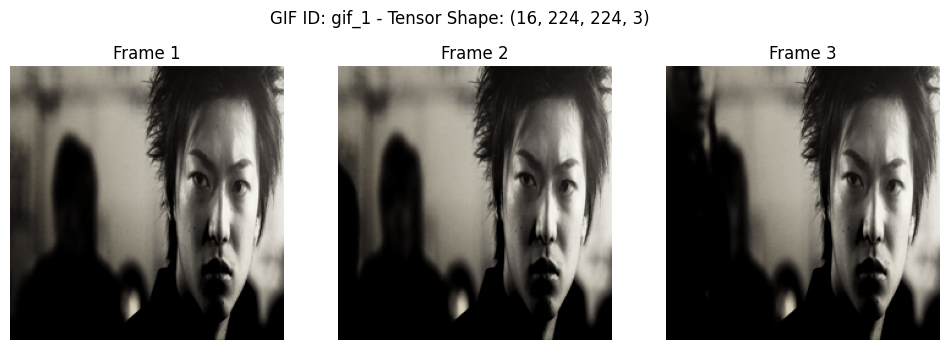

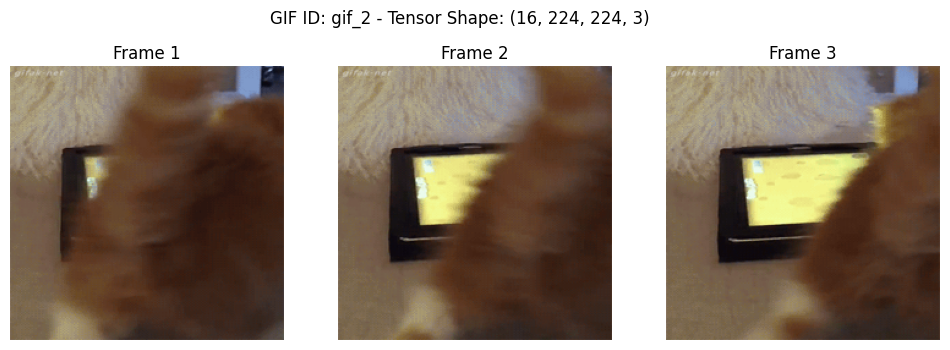

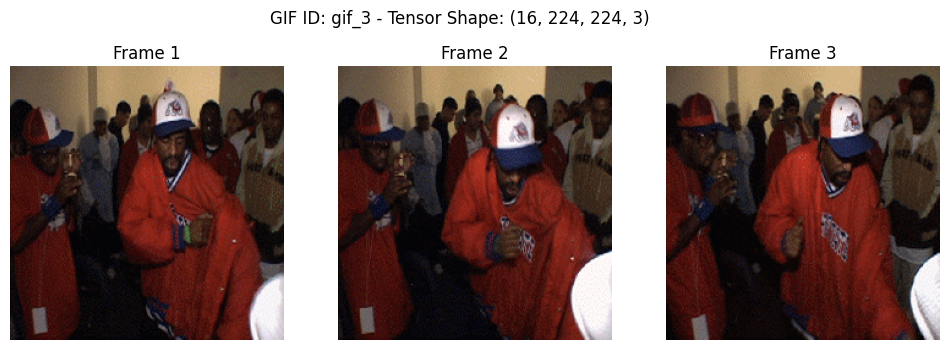

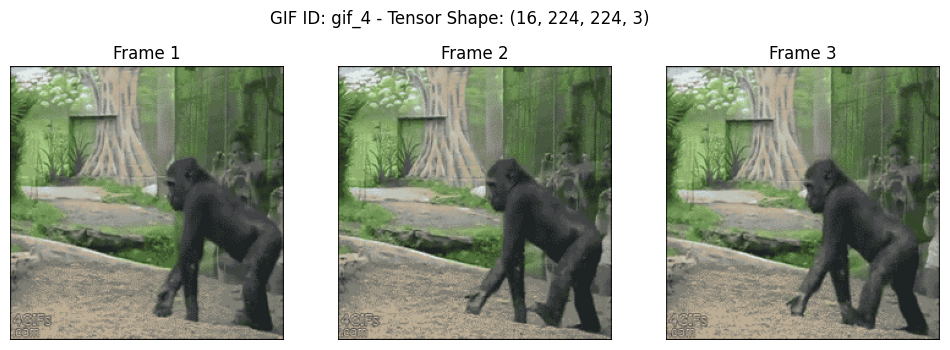

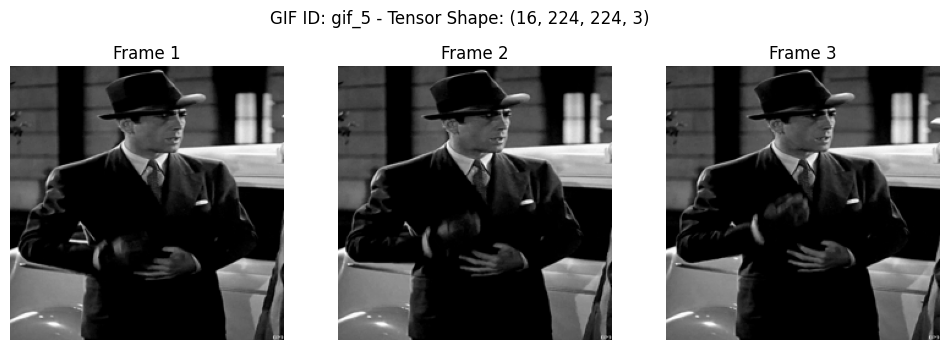

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from google.cloud import storage
from io import BytesIO

# Initialize Google Cloud Storage client
client = storage.Client()
bucket_name = "whathegifbucket"  # Replace with your actual GCS bucket name
bucket = client.get_bucket(bucket_name)

# Load GIF metadata from the JSON file
with open('gif_metadata_augmented.json', 'r') as f:
    gif_metadata = json.load(f)

# Function to load and visualize frames from 5 GIFs
def visualize_gif_tensors(metadata, num_gifs=5):
    for i, gif in enumerate(metadata[:num_gifs]):
        gif_id = gif["GIF_ID"]
        processed_gif_path = gif["processed_gif_path"]
        
        # Load the processed GIF from GCS
        blob = bucket.blob(processed_gif_path)
        gif_tensor = np.load(BytesIO(blob.download_as_bytes()))

        # Display the first 3 frames from each GIF to verify the processing
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        fig.suptitle(f'GIF ID: {gif_id} - Tensor Shape: {gif_tensor.shape}')
        
        for j in range(3):  # Display 3 frames
            axes[j].imshow(gif_tensor[j])
            axes[j].set_title(f'Frame {j+1}')
            axes[j].axis('off')
        
        plt.show()

# Visualize tensors for 5 GIFs
visualize_gif_tensors(gif_metadata, num_gifs=5)


In [15]:
import json
from google.cloud import storage

# Initialize Google Cloud Storage client
client = storage.Client()
bucket_name = "whathegifbucket"  # Replace with your actual GCS bucket name
bucket = client.get_bucket(bucket_name)

# Path to save the JSON file in GCS
json_file_name = "gif_metadata_augmented.json"
gcs_save_path = f"processed_gifs/{json_file_name}"

# Upload the JSON file to GCS
def upload_json_to_gcs(json_file_name, gcs_save_path):
    # Load the local JSON file
    with open(json_file_name, 'r') as json_file:
        json_data = json_file.read()

    # Upload the file to GCS
    blob = bucket.blob(gcs_save_path)
    blob.upload_from_string(json_data, content_type='application/json')
    print(f"JSON file saved to GCS at {gcs_save_path}")

# Save the JSON file to GCS
upload_json_to_gcs(json_file_name, gcs_save_path)


JSON file saved to GCS at processed_gifs/gif_metadata_augmented.json


In [18]:
json_file_name

'gif_metadata_augmented.json'

# Load the Dataset (GIF tensors from JSON metadata)

In [21]:
import json
import numpy as np
from google.cloud import storage
from io import BytesIO

# Initialize Google Cloud Storage client
client = storage.Client()
bucket_name = "whathegifbucket"  # Replace with your actual GCS bucket name
bucket = client.get_bucket(bucket_name)

# Load GIF metadata from the JSON file
json_file_name = "processed_gifs/gif_metadata_augmented.json"
blob = bucket.blob(json_file_name)
json_data = blob.download_as_string()
gif_metadata = json.loads(json_data)

# Function to load the processed GIF tensor from GCS
def load_gif_tensor(gif_metadata_entry):
    processed_gif_path = gif_metadata_entry['processed_gif_path']
    blob = bucket.blob(processed_gif_path)
    gif_tensor = np.load(BytesIO(blob.download_as_bytes()))
    return gif_tensor

# Load tensors for all GIFs
gif_tensors = [load_gif_tensor(gif) for gif in gif_metadata]


# Build the 3D CNN Model


We'll use a pretrained 3D CNN model and keep the flow simple, step-by-step. We’ll build on a pretrained 3D model (such as 3D ResNet) and freeze the layers. Then we’ll add custom layers for the specific task of GIF feature extraction and caption generation. We will also set up TensorBoard for monitoring the training.

Step-by-Step Plan:
- Load the Pretrained 3D CNN Model (like 3D ResNet).
- Freeze the Pretrained Layers and add your own layers on top.
- Prepare the Data (format the GIF tensors).
- Set Up TensorBoard (for monitoring the training process).
- Train the Model with TensorBoard tracking.

1. Loading the Pretrained Model (3D ResNet):
Purpose: We are using a pretrained 3D ResNet-18 model because it has already learned useful spatiotemporal features from video data (Kinetics dataset). By freezing its layers, we retain this knowledge without changing it during training.

In [26]:
!pip install torch torchvision


  Using cached torch-2.4.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Usin

In [27]:
import torch
import torch.nn as nn
import torchvision.models.video as video_models

# Load the pretrained 3D ResNet model
pretrained_model = video_models.r3d_18(pretrained=True)  # 3D ResNet 18-layer model
pretrained_model.eval()  # Set to evaluation mode

# Freeze the layers of the pretrained model
for param in pretrained_model.parameters():
    param.requires_grad = False

# Custom 3D CNN model for processing GIF frames
class Custom3DCNN(nn.Module):
    def __init__(self):
        super(Custom3DCNN, self).__init__()
        
        # Use the pretrained ResNet3D (already trained on spatiotemporal data)
        self.pretrained_3dcnn = pretrained_model
        
        # Fully connected layers to further process the extracted features
        # Adjust input size based on the pretrained ResNet3D output size
        self.fc1 = nn.Linear(512, 256)  # The output from ResNet3D is a 512-dimensional vector
        self.fc2 = nn.Linear(256, 128)  # Further reduce the dimensionality for feature extraction
        
    def forward(self, x):
        # Pass the input (GIF frames) through the pretrained 3D ResNet
        x = self.pretrained_3dcnn(x)
        
        # Flatten the output to prepare for fully connected layers
        x = torch.flatten(x, 1)  # Flatten to (batch_size, flattened_size)
        
        # Pass through the custom fully connected layers
        x = nn.ReLU()(self.fc1(x))  # Apply ReLU activation after the first fully connected layer
        x = nn.ReLU()(self.fc2(x))  # Apply ReLU activation after the second fully connected layer
        
        # The output is a 128-dimensional feature vector (can be used for further tasks, like caption generation)
        return x

# Instantiate the custom model
model = Custom3DCNN()

# Print the model architecture
print(model)



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /home/jupyter/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:00<00:00, 195MB/s]  


Custom3DCNN(
  (pretrained_3dcnn): VideoResNet(
    (stem): BasicStem(
      (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Sequential(
          (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (conv2): Sequential(
          (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Sequential(
          (0): Conv3DSimple(64, 64, kernel_

In [29]:
!pip install torchsummary


# Move Model to GPU

In [35]:
import torch
import torch.nn as nn
import torchvision.models.video as video_models

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the pretrained 3D ResNet model and move to GPU
pretrained_model = video_models.r3d_18(pretrained=True).to(device)  # 3D ResNet 18-layer model
pretrained_model.eval()  # Set to evaluation mode

# Freeze the layers of the pretrained model
for param in pretrained_model.parameters():
    param.requires_grad = False

# Custom 3D CNN model for processing GIF frames
class Custom3DCNN(nn.Module):
    def __init__(self):
        super(Custom3DCNN, self).__init__()
        
        # Use the pretrained ResNet3D (already trained on spatiotemporal data)
        self.pretrained_3dcnn = pretrained_model
        
        # Adjust input size to match the ResNet3D output (400 features instead of 512)
        self.fc1 = nn.Linear(400, 256)  # Now takes 400 features from the ResNet3D
        self.fc2 = nn.Linear(256, 128)  # Further reduce the dimensionality for feature extraction
        
    def forward(self, x):
        # Pass the input (GIF frames) through the pretrained 3D ResNet
        x = self.pretrained_3dcnn(x)
        
        # Flatten the output to prepare for fully connected layers
        x = torch.flatten(x, 1)  # Flatten to (batch_size, flattened_size)
        
        # Pass through the custom fully connected layers
        x = nn.ReLU()(self.fc1(x))  # Apply ReLU activation after the first fully connected layer
        x = nn.ReLU()(self.fc2(x))  # Apply ReLU activation after the second fully connected layer
        
        return x

# Instantiate the model and move it to GPU
model = Custom3DCNN().to(device)

# Print the model architecture
print(model)

# Example input (16 frames of size 224x224 with 3 channels, batch size = 1) moved to GPU
input_tensor = torch.randn(1, 3, 16, 224, 224).to(device)

# Forward pass through the model
output = model(input_tensor)

# Print the output shape
print(f"Output shape: {output.shape}")


Using device: cuda
Custom3DCNN(
  (pretrained_3dcnn): VideoResNet(
    (stem): BasicStem(
      (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Sequential(
          (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (conv2): Sequential(
          (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Sequential(
          (0): Conv3DSim

# Split the Data

In [43]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# Splitting the indices for training, validation, and testing
train_idx, val_test_idx = train_test_split(range(len(gif_metadata)), test_size=0.30, random_state=42)
val_idx, test_idx = train_test_split(val_test_idx, test_size=0.50, random_state=42)


# Modify the __getitem__ method in GIFDataset to permute the input correctly
class GIFDataset(Dataset):
    def __init__(self, metadata, indices):
        self.metadata = [metadata[i] for i in indices]  # Select the subset of data based on the indices

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        # Get metadata for the current GIF
        gif_meta = self.metadata[idx]

        # Load the processed GIF tensor from GCS
        processed_gif_path = gif_meta['processed_gif_path']
        blob = bucket.blob(processed_gif_path)
        gif_tensor = np.load(BytesIO(blob.download_as_bytes()))

        # Convert to PyTorch tensor and permute to (channels, num_frames, height, width)
        gif_tensor = torch.tensor(gif_tensor, dtype=torch.float32).permute(3, 0, 1, 2)  # (frames, height, width, channels) -> (channels, num_frames, height, width)

        # Return the GIF tensor and description
        description = gif_meta['description']
        return gif_tensor, description

# Create datasets for training, validation, and test
train_dataset = GIFDataset(gif_metadata, train_idx)
val_dataset = GIFDataset(gif_metadata, val_idx)
test_dataset = GIFDataset(gif_metadata, test_idx)

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [44]:
# Get a single batch from the train_loader
for inputs, descriptions in train_loader:
    print(f"Input shape: {inputs.shape}")
    print(f"Description: {descriptions[0]}")
    break


Input shape: torch.Size([8, 3, 16, 224, 224])
Description: a young white boy in white shirt is brushing his hair


# Training with Validation test 1

In [45]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir='./runs/3dcnn_gif_experiment')

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Example self-supervised loss, adjust as needed
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with validation
def train_model(model, train_loader, val_loader, num_epochs=8):
    model.train()  # Set model to training mode

    for epoch in range(num_epochs):
        running_loss = 0.0
        
        # Training step
        for i, (inputs, descriptions) in enumerate(train_loader):
            inputs = inputs.to(device)  # Move inputs to GPU
            optimizer.zero_grad()  # Zero the parameter gradients

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, outputs)  # Example self-supervised loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            writer.add_scalar('training_loss', running_loss / (i + 1), epoch * len(train_loader) + i)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss / len(train_loader)}")

        # Validation step
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for i, (inputs, descriptions) in enumerate(val_loader):
                inputs = inputs.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, outputs)
                val_loss += loss.item()

        writer.add_scalar('validation_loss', val_loss / len(val_loader), epoch)
        print(f"Validation Loss after Epoch {epoch+1}: {val_loss / len(val_loader)}")

    writer.close()  # Close the TensorBoard writer

# Train the model
train_model(model, train_loader, val_loader, num_epochs=8)


Epoch [1/8], Training Loss: 0.0
Validation Loss after Epoch 1: 0.0
Epoch [2/8], Training Loss: 0.0
Validation Loss after Epoch 2: 0.0
Epoch [3/8], Training Loss: 0.0
Validation Loss after Epoch 3: 0.0
Epoch [4/8], Training Loss: 0.0
Validation Loss after Epoch 4: 0.0
Epoch [5/8], Training Loss: 0.0
Validation Loss after Epoch 5: 0.0
Epoch [6/8], Training Loss: 0.0
Validation Loss after Epoch 6: 0.0
Epoch [7/8], Training Loss: 0.0
Validation Loss after Epoch 7: 0.0
Epoch [8/8], Training Loss: 0.0
Validation Loss after Epoch 8: 0.0


In [47]:
#tensorboard --logdir=runs/3dcnn_gif_experiment


# Mid Point Gif Checks

In [48]:
def validate_gif_tensors(gif_tensors):
    for i, gif_tensor in enumerate(gif_tensors):
        print(f"Validating GIF {i + 1}/{len(gif_tensors)}:")
        
        # Check if the tensor is a numpy array
        if not isinstance(gif_tensor, np.ndarray):
            print(f"  Error: GIF {i + 1} is not a numpy array.")
            continue
        
        # Check the shape of the tensor
        if gif_tensor.ndim != 4:
            print(f"  Error: GIF {i + 1} does not have 4 dimensions, got {gif_tensor.ndim} dimensions.")
            continue
        
        frames, height, width, channels = gif_tensor.shape
        print(f"  Shape: {gif_tensor.shape}")
        
        # Check if the number of channels is 3 (RGB)
        if channels != 3:
            print(f"  Error: GIF {i + 1} does not have 3 channels, got {channels} channels.")
            continue
        
        # Check if the height and width are consistent (e.g., 224x224)
        if height != 224 or width != 224:
            print(f"  Warning: GIF {i + 1} has dimensions {height}x{width}. Expected 224x224.")
        
        # Check the data type
        if gif_tensor.dtype != np.float32:
            print(f"  Warning: GIF {i + 1} is not of type float32, got {gif_tensor.dtype}.")
        
        print(f"  GIF {i + 1} passed validation.\n")

# Validate the loaded GIF tensors
validate_gif_tensors(gif_tensors)


Validating GIF 1/98:
  Shape: (16, 224, 224, 3)
  GIF 1 passed validation.

Validating GIF 2/98:
  Shape: (16, 224, 224, 3)
  GIF 2 passed validation.

Validating GIF 3/98:
  Shape: (16, 224, 224, 3)
  GIF 3 passed validation.

Validating GIF 4/98:
  Shape: (16, 224, 224, 3)
  GIF 4 passed validation.

Validating GIF 5/98:
  Shape: (16, 224, 224, 3)
  GIF 5 passed validation.

Validating GIF 6/98:
  Shape: (16, 224, 224, 3)
  GIF 6 passed validation.

Validating GIF 7/98:
  Shape: (16, 224, 224, 3)
  GIF 7 passed validation.

Validating GIF 8/98:
  Shape: (16, 224, 224, 3)
  GIF 8 passed validation.

Validating GIF 9/98:
  Shape: (16, 224, 224, 3)
  GIF 9 passed validation.

Validating GIF 10/98:
  Shape: (16, 224, 224, 3)
  GIF 10 passed validation.

Validating GIF 11/98:
  Shape: (16, 224, 224, 3)
  GIF 11 passed validation.

Validating GIF 12/98:
  Shape: (16, 224, 224, 3)
  GIF 12 passed validation.

Validating GIF 13/98:
  Shape: (16, 224, 224, 3)
  GIF 13 passed validation.

Vali

# Convert and Normalize GIF Tensors

In [49]:
def validate_and_convert_gif_tensors(gif_tensors):
    converted_gif_tensors = []  # List to store the converted tensors
    
    for i, gif_tensor in enumerate(gif_tensors):
        print(f"Validating GIF {i + 1}/{len(gif_tensors)}:")
        
        # Check the shape of the tensor
        if gif_tensor.ndim != 4:
            print(f"  Error: GIF {i + 1} does not have 4 dimensions, got {gif_tensor.ndim} dimensions.")
            continue
        
        frames, height, width, channels = gif_tensor.shape
        print(f"  Shape: {gif_tensor.shape}")
        
        # Check if the number of channels is 3 (RGB)
        if channels != 3:
            print(f"  Error: GIF {i + 1} does not have 3 channels, got {channels} channels.")
            continue
        
        # Convert to float32 and normalize to [0, 1]
        if gif_tensor.dtype == np.uint8:
            print(f"  Warning: GIF {i + 1} is not of type float32, converting and normalizing...")
            gif_tensor = gif_tensor.astype(np.float32) / 255.0  # Convert to float32 and normalize
            
        # Store the converted tensor
        converted_gif_tensors.append(gif_tensor)
        
        print(f"  GIF {i + 1} passed validation and conversion.\n")
    
    return converted_gif_tensors

# Validate and convert the loaded GIF tensors
gif_tensors = validate_and_convert_gif_tensors(gif_tensors)


Validating GIF 1/98:
  Shape: (16, 224, 224, 3)
  GIF 1 passed validation and conversion.

Validating GIF 2/98:
  Shape: (16, 224, 224, 3)
  GIF 2 passed validation and conversion.

Validating GIF 3/98:
  Shape: (16, 224, 224, 3)
  GIF 3 passed validation and conversion.

Validating GIF 4/98:
  Shape: (16, 224, 224, 3)
  GIF 4 passed validation and conversion.

Validating GIF 5/98:
  Shape: (16, 224, 224, 3)
  GIF 5 passed validation and conversion.

Validating GIF 6/98:
  Shape: (16, 224, 224, 3)
  GIF 6 passed validation and conversion.

Validating GIF 7/98:
  Shape: (16, 224, 224, 3)
  GIF 7 passed validation and conversion.

Validating GIF 8/98:
  Shape: (16, 224, 224, 3)
  GIF 8 passed validation and conversion.

Validating GIF 9/98:
  Shape: (16, 224, 224, 3)
  GIF 9 passed validation and conversion.

Validating GIF 10/98:
  Shape: (16, 224, 224, 3)
  GIF 10 passed validation and conversion.

Validating GIF 11/98:
  Shape: (16, 224, 224, 3)
  GIF 11 passed validation and conversi

# Feature Extraction using the 3D CNN


In [50]:
import torch

# Move model to the appropriate device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Pass the normalized GIF tensors through the model to extract feature vectors
def extract_features_from_gifs(model, gif_tensors):
    model.eval()  # Set model to evaluation mode
    all_features = []  # To store the extracted feature vectors
    
    with torch.no_grad():  # Disable gradient calculations for inference
        for i, gif_tensor in enumerate(gif_tensors):
            # Convert the tensor to PyTorch tensor and permute to (channels, frames, height, width)
            gif_tensor = torch.tensor(gif_tensor, dtype=torch.float32).permute(3, 0, 1, 2).unsqueeze(0)  # Add batch dimension
            gif_tensor = gif_tensor.to(device)  # Move tensor to GPU if available
            
            # Pass the GIF tensor through the model to extract features
            features = model(gif_tensor)
            all_features.append(features.cpu().numpy())  # Store the feature vector, move back to CPU
            
            print(f"Processed GIF {i + 1}/{len(gif_tensors)} - Extracted features of shape: {features.shape}")
    
    return all_features

# Extract features from the GIFs
extracted_features = extract_features_from_gifs(model, gif_tensors)


Processed GIF 1/98 - Extracted features of shape: torch.Size([1, 128])
Processed GIF 2/98 - Extracted features of shape: torch.Size([1, 128])
Processed GIF 3/98 - Extracted features of shape: torch.Size([1, 128])
Processed GIF 4/98 - Extracted features of shape: torch.Size([1, 128])
Processed GIF 5/98 - Extracted features of shape: torch.Size([1, 128])
Processed GIF 6/98 - Extracted features of shape: torch.Size([1, 128])
Processed GIF 7/98 - Extracted features of shape: torch.Size([1, 128])
Processed GIF 8/98 - Extracted features of shape: torch.Size([1, 128])
Processed GIF 9/98 - Extracted features of shape: torch.Size([1, 128])
Processed GIF 10/98 - Extracted features of shape: torch.Size([1, 128])
Processed GIF 11/98 - Extracted features of shape: torch.Size([1, 128])
Processed GIF 12/98 - Extracted features of shape: torch.Size([1, 128])
Processed GIF 13/98 - Extracted features of shape: torch.Size([1, 128])
Processed GIF 14/98 - Extracted features of shape: torch.Size([1, 128])
P

In [51]:
# Check a few feature vectors
for i, feature_vector in enumerate(extracted_features[:5]):  # Check the first 5 GIFs
    print(f"Feature Vector for GIF {i + 1}: {feature_vector}")


Feature Vector for GIF 1: [[0.00000000e+00 1.03775375e-01 0.00000000e+00 7.24072531e-02
  0.00000000e+00 3.25840622e-01 0.00000000e+00 2.74826139e-01
  8.80770445e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  6.14618003e-01 0.00000000e+00 2.93595344e-01 0.00000000e+00
  2.67781198e-01 1.58460721e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.56754422e-01 9.35967192e-02
  3.07903290e-02 0.00000000e+00 3.68176326e-02 0.00000000e+00
  1.33745223e-01 0.00000000e+00 0.00000000e+00 4.36229974e-01
  0.00000000e+00 1.34161234e-01 3.80921125e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.65398943e-01 0.00000000e+00
  1.60293669e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.29688752e-01 0.00000000e+00 5.59132576e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.60220671e-01 5.72157681e-01
  8.57394814e-01 1.46709442e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.00961882e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 4.56913561e-

# Training and Monitoring